<a href="https://colab.research.google.com/github/adamnpeace/deep-learning-cw2/blob/master/q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from torchtext import data
from torchtext import vocab
from torchtext.vocab import Vectors
from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
!unzip -q -o -d ./data /tmp/trainDevTestTrees_PTB.zip
!rm -f /tmp/trainDevTestTrees_PTB.zip

In [3]:
def loadsst(path):
    xs = []
    ys = []
    file1 = open(path, 'r')
    Lines = file1.readlines()
    for line in Lines:
        soup = line.split()
        ys.append(int(soup[0].lstrip('(')))
        tokens = []
        for chunk in soup[2:]:
            if not chunk.endswith(")"):
                continue
            tokens.append(chunk.rstrip(')'))
        xs.append(tokens)
    return xs, ys

ssttrainxs, ssttrainys = loadsst("./data/trees/train.txt")
sstvalidxs, sstvalidys = loadsst("./data/trees/dev.txt")
ssttestxs, ssttestys = loadsst("./data/trees/test.txt")

In [4]:
trainx = pd.DataFrame.from_records([[' '.join(x)] for x in ssttrainxs])
trainy = pd.DataFrame(ssttrainys)
validx = pd.DataFrame.from_records([[' '.join(x)] for x in sstvalidxs])
validy = pd.DataFrame(sstvalidys)
testx = pd.DataFrame.from_records([[' '.join(x)] for x in ssttestxs])
testy = pd.DataFrame(ssttestys)
train = pd.concat([trainx, trainy], axis=1)
valid = pd.concat([validx, validy], axis=1)
test = pd.concat([testx, testy], axis=1)
train.to_csv('/tmp/train.csv', index=False)
valid.to_csv('/tmp/valid.csv', index=False)
test.to_csv('/tmp/test.csv', index=False)

In [5]:
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField()
fields = [('Text', TEXT), ('Label', LABEL)]

trainds, valds, testds = data.TabularDataset.splits(path='/tmp', 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='valid.csv', 
                                            test='test.csv',
                                            fields=fields, 
                                            skip_header=True)

In [6]:
# load pretrained vectors
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

In [7]:
TEXT.build_vocab(trainds)


In [8]:
LABEL.build_vocab(trainds)


In [9]:
embedding_matrix = np.zeros((len(TEXT.vocab), 300))

In [10]:
for index,word in enumerate(TEXT.vocab.stoi):
  try:
      # update embedding matrix using pretrained vectors if defined
      embedding_matrix[index] = model[word] 
  except:
      # else keep as zero
      pass

In [11]:
# we want to convert it to a tensor when done
em = torch.from_numpy(embedding_matrix)
em.shape

torch.Size([17199, 300])

In [12]:
em

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0435, -0.0859, -0.1069,  ..., -0.5273,  0.2578, -0.0698],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4336,  0.0195,  0.2129,  ..., -0.0796, -0.0243,  0.3965]],
       dtype=torch.float64)

In [13]:
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f38bd1e4b70>, {'3': 0, '1': 1, '2': 2, '4': 3, '0': 4})


In [14]:
print(TEXT.vocab.freqs.most_common(20))

[('.', 8041), (',', 7131), ('the', 6087), ('and', 4474), ('of', 4446), ('a', 4423), ('to', 3024), ('-', 2739), ("'s", 2544), ('is', 2540), ('that', 1916), ('in', 1817), ('it', 1781), ('The', 1265), ('as', 1203), ('film', 1156), ('but', 1076), ('with', 1071), ('movie', 999), ('for', 977)]


In [77]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (trainds, valds, testds), 
    batch_size = BATCH_SIZE)


In [78]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [79]:
class Model(nn.Module):
    def __init__(
        self, vocab_size, embed_dim, pretrained_vec, 
        num_hidden_rnn, num_rnn_layers, 
        mlp_layers, num_classes,
        rec_unit_type, train_embeddings=False
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_hidden_rnn = num_hidden_rnn
        self.num_rnn_layers = num_rnn_layers
        self.mlp_layers = mlp_layers
        self.num_classes = num_classes
        
        self.embeddings = nn.Embedding(self.vocab_size, self.embed_dim)
        self.embeddings.weight.data.copy_(pretrained_vec) # Load pretrained embeddings
        self.embeddings.weight.requires_grad = train_embeddings  # Decide if embeddings get updated or not

        # Define RNN layers using "vanilla" RNN, GRU or LSTM
        if (rec_unit_type == "RNN"):
            self.rec = nn.RNN(
                input_size=self.embed_dim, 
                hidden_size=self.num_hidden_rnn, 
                num_layers=num_rnn_layers)
        elif (rec_unit_type == "GRU"):
            self.rec = nn.GRU(
                input_size=self.embed_dim, 
                hidden_size=self.num_hidden_rnn, 
                num_layers=num_rnn_layers)
        elif (rec_unit_type == "LSTM"):
            self.rec = nn.LSTM(
                input_size=self.embed_dim, 
                hidden_size=self.num_hidden_rnn,
                num_layers=num_rnn_layers)

        # Define MLP layers
        self.mlp = nn.ModuleList()
        for i, hidden_layer in enumerate(mlp_layers):
            if i == 0:
                self.mlp.append(nn.Linear(self.num_hidden_rnn, hidden_layer))
            else:
                self.mlp.append(nn.Linear(mlp_layers[i-1], hidden_layer))

        # Define final output layer
        self.out = nn.Linear(mlp_layers[-1], self.num_classes)
        
    def forward(self, X):
        # Re-initialize hidden states for each batch, so we are not sharing hidden states across batches
        self.h = self.init_hidden(self.num_rnn_layers, 300)
        
        # Convert words into embeddings
        embeddings = self.embeddings(X)
        
        # Pass through RNN layer and get hidden state at last timestep
        output, self.h = self.rec(embeddings, self.h)
        
        # LSTM returns a tuple of hidden state and cell state, so pick hidden state only
        if (rec_unit_type == "LSTM"):
            self.h = self.h[0]
            
        # Pass through MLP layer with RELU activation function
        out = F.relu(self.mlp[0](self.h[-1]))
        for i in range(1, len(self.mlp)):
            out = F.relu(self.mlp[i](out))
        
        return self.out(out)
    
    def init_hidden(self, num_layers, batch_size): 
        if (rec_unit_type == "LSTM"):
            self.h = (Variable(torch.zeros((num_layers,batch_size,self.num_hidden_rnn))).to(device),
                      Variable(torch.zeros((num_layers,batch_size,self.num_hidden_rnn))).to(device))
        else:
            self.h = Variable(torch.zeros((num_layers,batch_size,self.num_hidden_rnn))).to(device)

In [80]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs, batch_size):
    measurements = {
        "Train Loss": [],
        "Train Acc": [],
        "Val Loss": [],
        "Val Acc": [],
        "Lowest Val Loss": np.Inf,
        "Lowest Val Loss Epoch": np.Inf
    }
    lowest_val_loss = np.Inf
    lowest_val_loss_epoch = np.Inf
    
    for epoch in range(epochs):
        # Training
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0  
        
        model.train() # Set model in train mode
        
        for X,y in iter(train_dl):
            opt.zero_grad() # Clear old gradients
            pred = model(X) # Make prediction using model
            loss = loss_fn(pred, y)
            loss.backward() # Compute derivatives of loss w.r.t. parameters using backpropagation
            opt.step() # Take a step using computed gradients
            pred_idx = torch.max(pred, 1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
        
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        measurements["Train Acc"].append(train_acc)
        measurements["Train Loss"].append(train_loss)
        
        # Validation
        y_true_val = list()
        y_pred_val = list()
        total_loss_val = 0
        
        model.eval() # Set model in eval mode

        for X,y in iter(val_dl):
            pred = model(X)
            loss = loss_fn(pred, y)
            pred_idx = torch.max(pred, 1)[1]

            y_true_val += list(y.cpu().data.numpy())
            y_pred_val += list(pred_idx.cpu().data.numpy())
            total_loss_val += loss.item()
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_loss = total_loss_val/len(val_dl)
        measurements["Val Acc"].append(val_acc)
        measurements["Val Loss"].append(val_loss)
        
        if (val_loss < measurements["Lowest Val Loss"]):
            torch.save(model.state_dict(), 'checkpoint.pt')
            measurements["Lowest Val Loss"] = val_loss
            measurements["Lowest Val Loss Epoch"] = epoch
        
        print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        
    # Return model checkpoint stored at lowest validation loss
    model.load_state_dict(torch.load('checkpoint.pt'))
    print(f'Lowest val_loss: {measurements["Lowest Val Loss"]:.4f}, at epoch {measurements["Lowest Val Loss Epoch"]}')
    
    return model, measurements

In [81]:
batch_size = 128
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds),
                                            batch_sizes=(batch_size, batch_size),
                                            sort_key=lambda x: len(x.Text),
                                            device=device,
                                            sort_within_batch=False)
train_batch_it = BatchGenerator(traindl, 'Text', 'Label')
val_batch_it = BatchGenerator(valdl, 'Text', 'Label')



In [96]:
vocab_size = len(TEXT.vocab)
embedding_dim = 300
num_hidden_rnn = 50
num_rnn_layers = 2
mlp_layers = [50]
num_classes = 5
rec_unit_type = "GRU"
train_embeddings = False

m = Model(
    vocab_size, 
    embedding_dim, 
    torch.from_numpy(embedding_matrix),
    num_hidden_rnn, 
    num_rnn_layers, 
    mlp_layers, 
    num_classes, 
    rec_unit_type, 
    train_embeddings).to(device)
# Filter is in place to ensure only layers with "requires_grad" will have their weights updated
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 0.001)


print(m)

Model(
  (embeddings): Embedding(17199, 300)
  (rec): GRU(300, 50, num_layers=2)
  (mlp): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
  (out): Linear(in_features=50, out_features=5, bias=True)
)


In [97]:
m, measurements = fit(
    model=m,
    train_dl=train_batch_it, 
    val_dl=val_batch_it, 
    loss_fn=F.cross_entropy,
    opt=opt,
    epochs=100,
    batch_size=batch_size)

Epoch 0: train_loss: 1.5768 train_acc: 0.2561 | val_loss: 1.5733 val_acc: 0.2534
Epoch 1: train_loss: 1.5691 train_acc: 0.2670 | val_loss: 1.5775 val_acc: 0.2534
Epoch 2: train_loss: 1.5691 train_acc: 0.2704 | val_loss: 1.5720 val_acc: 0.2534
Epoch 3: train_loss: 1.5685 train_acc: 0.2684 | val_loss: 1.5737 val_acc: 0.2534
Epoch 4: train_loss: 1.5681 train_acc: 0.2659 | val_loss: 1.5707 val_acc: 0.2543
Epoch 5: train_loss: 1.5675 train_acc: 0.2712 | val_loss: 1.5737 val_acc: 0.2543
Epoch 6: train_loss: 1.5549 train_acc: 0.2908 | val_loss: 1.4647 val_acc: 0.3742
Epoch 7: train_loss: 1.3531 train_acc: 0.3950 | val_loss: 1.3272 val_acc: 0.3933
Epoch 8: train_loss: 1.2584 train_acc: 0.4327 | val_loss: 1.3139 val_acc: 0.4332
Epoch 9: train_loss: 1.2136 train_acc: 0.4533 | val_loss: 1.2870 val_acc: 0.4369
Epoch 10: train_loss: 1.1835 train_acc: 0.4716 | val_loss: 1.3334 val_acc: 0.4214
Epoch 11: train_loss: 1.1598 train_acc: 0.4841 | val_loss: 1.3064 val_acc: 0.4251
Epoch 12: train_loss: 1.13

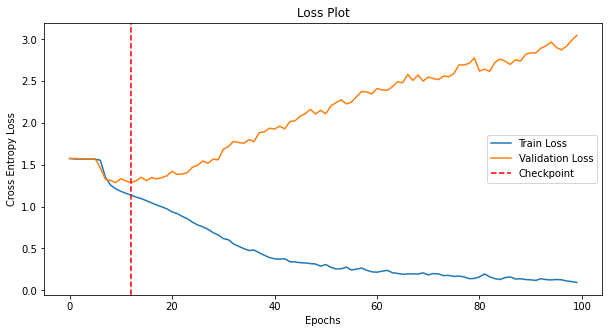

In [98]:

plt.figure(figsize=(10,5))
plt.plot(measurements["Train Loss"], label="Train Loss")
plt.plot(measurements["Val Loss"], label="Validation Loss")
plt.axvline(measurements["Lowest Val Loss Epoch"], linestyle='--', color='r',label='Checkpoint')
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()

In [99]:
testdl = data.Iterator(testds,
                        batch_size=batch_size,
                        sort_key=lambda x: len(x.Text),
                        device=device,
                        sort_within_batch=False)
test_batch_it = BatchGenerator(testdl, 'Text', 'Label')
m.eval()
loss_fn=F.cross_entropy
accuracies = []

for batch_it in [train_batch_it, val_batch_it, test_batch_it]:
  y_true = list()
  y_pred = list()
  total_loss = 0

  for X,y in iter(batch_it):
      pred = m(X)
      loss = loss_fn(pred, y)
      pred_idx = torch.max(pred, 1)[1]

      y_true += list(y.cpu().data.numpy())
      y_pred += list(pred_idx.cpu().data.numpy())
      total_loss += loss.item()

  acc = accuracy_score(y_true, y_pred)
  accuracies.append(acc)

In [100]:
print(f'Training Accuracy: {accuracies[0]:.4f}')
print(f'Validation Accuracy: {accuracies[1]:.4f}')
print(f'Test Accuracy: {accuracies[2]:.4f}')

Training Accuracy: 0.5092
Validation Accuracy: 0.4360
Test Accuracy: 0.4462


In [101]:
# Movie reviews from:
# https://www.rottentomatoes.com/m/the_dark_knight

reviews = [
    "An exceptionally smart, brooding picture with some terrific performances.",
    "You will feel utterly numb after the screening of The Dark Knight. The film is bleak and brilliant.",
    "The definitive movie of its genre and the best Batman film to date",
    "Too much psychology and not enough pop. It's possible to be too serious, you know.",
    "One of the most stylish extravaganzas in years.",
]
field = [('Text', TEXT)]
my_examples = pd.DataFrame({'text': reviews})
my_examples.to_csv('/tmp/my_examples.csv', index=False)
my_ds = data.TabularDataset(path='/tmp/my_examples.csv', 
                            format='csv', 
                            fields=field, 
                            skip_header=True)
my_dl = data.Iterator(my_ds, batch_size=5, device=device)
my_it = BatchGenerator(my_dl, 'Text', 'Text')
m.eval()

X,_ = next(iter(my_it))
pred = m(X)
pred_idx = torch.max(pred, 1)[1].cpu().data.numpy()
for i in range(len(pred_idx)):
  print("Sentiment: {}. Review: {}".format(pred_idx[i], reviews[i]))


Sentiment: 0. Review: An exceptionally smart, brooding picture with some terrific performances.
Sentiment: 4. Review: You will feel utterly numb after the screening of The Dark Knight. The film is bleak and brilliant.
Sentiment: 1. Review: The definitive movie of its genre and the best Batman film to date
Sentiment: 0. Review: Too much psychology and not enough pop. It's possible to be too serious, you know.
Sentiment: 3. Review: One of the most stylish extravaganzas in years.
